In [1]:
#libraries
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read data
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [3]:
#Show first 10 columns
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.00
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2.0,10.82,1.0,N,138,181,1,45.7,6.0,0.5,10.00,0.0,1.0,64.95,0.0,1.75
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0.0,3.00,1.0,N,246,231,2,25.4,3.5,0.5,0.00,0.0,1.0,30.40,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,N,161,261,2,31.0,1.0,0.5,0.00,0.0,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,N,113,113,2,3.0,1.0,0.5,0.00,0.0,1.0,8.00,2.5,0.00


In [4]:
# Show types of data
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [5]:
#Create objective label:  duration of travel in minutes
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [6]:
df.duration.mean()

np.float64(15.612950619257845)

In [7]:
df.duration.std()

np.float64(34.851053592212814)

In [9]:
# Dropping outliers
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

97.78326020432945

In [10]:
# Clean the dataframe
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

In [11]:
# Select categorical features
categorical = ['PULocationID', 'DOLocationID']

In [12]:
df[categorical] = df[categorical].astype(str)

In [13]:
train_dicts = df[categorical].to_dict(orient='records')

In [14]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [15]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (2898906, 518)


In [16]:
#Training model
target = 'duration'
y_train = df[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 7.946174674221988


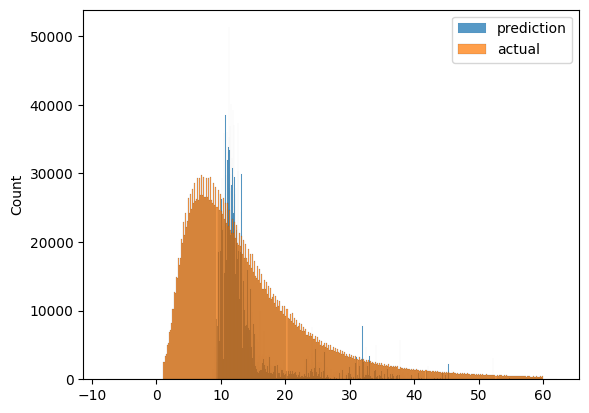

In [18]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

In [19]:
#Create a function for pre- process data

categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [21]:
#Read data val
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet')

In [22]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [23]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [24]:
y_pred = lr.predict(X_val)

In [25]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 8.123392575033122
